<a href="https://colab.research.google.com/github/WilliamShengYangHuang/RC18_Machine_Learning/blob/main/Feature_based_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image as image_utils
from sklearn.decomposition import PCA
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Set grid number each direction
grid_size = 64 #@param{type:"integer"}

# Total grid number
size_sqr = grid_size**2

# Get the path of the image folder
folder_path = '/content/drive/My Drive/Teaching/AA/Landscape_pinterest/2/' #@param{type:"string"}

1/1 [==============================] - 0s 20ms/step
Could not read image: /content/drive/My Drive/Teaching/AA/Landscape_pinterest/2/eba224b770daa4edd2c0e4189685675a.gif
Could not read image: /content/drive/My Drive/Teaching/AA/Landscape_pinterest/2/83d094e5da021907b2f4474324ab0935.gif
Could not read image: /content/drive/My Drive/Teaching/AA/Landscape_pinterest/2/d8f82234f750c85dfe64b46efe3c76e6.gif
Could not read image: /content/drive/My Drive/Teaching/AA/Landscape_pinterest/2/de862bff6c251c0141c735c0d9bfd4ed.gif
Could not read image: /content/drive/My Drive/Teaching/AA/Landscape_pinterest/2/27367c450c0bbf7c4b0e4f028fdf2669.gif
Could not read image: /content/drive/My Drive/Teaching/AA/Landscape_pinterest/2/eba224b770daa4edd2c0e4189685675a.gif
Could not read image: /content/drive/My Drive/Teaching/AA/Landscape_pinterest/2/83d094e5da021907b2f4474324ab0935.gif
Could not read image: /content/drive/My Drive/Teaching/AA/Landscape_pinterest/2/d8f82234f750c85dfe64b46efe3c76e6.gif


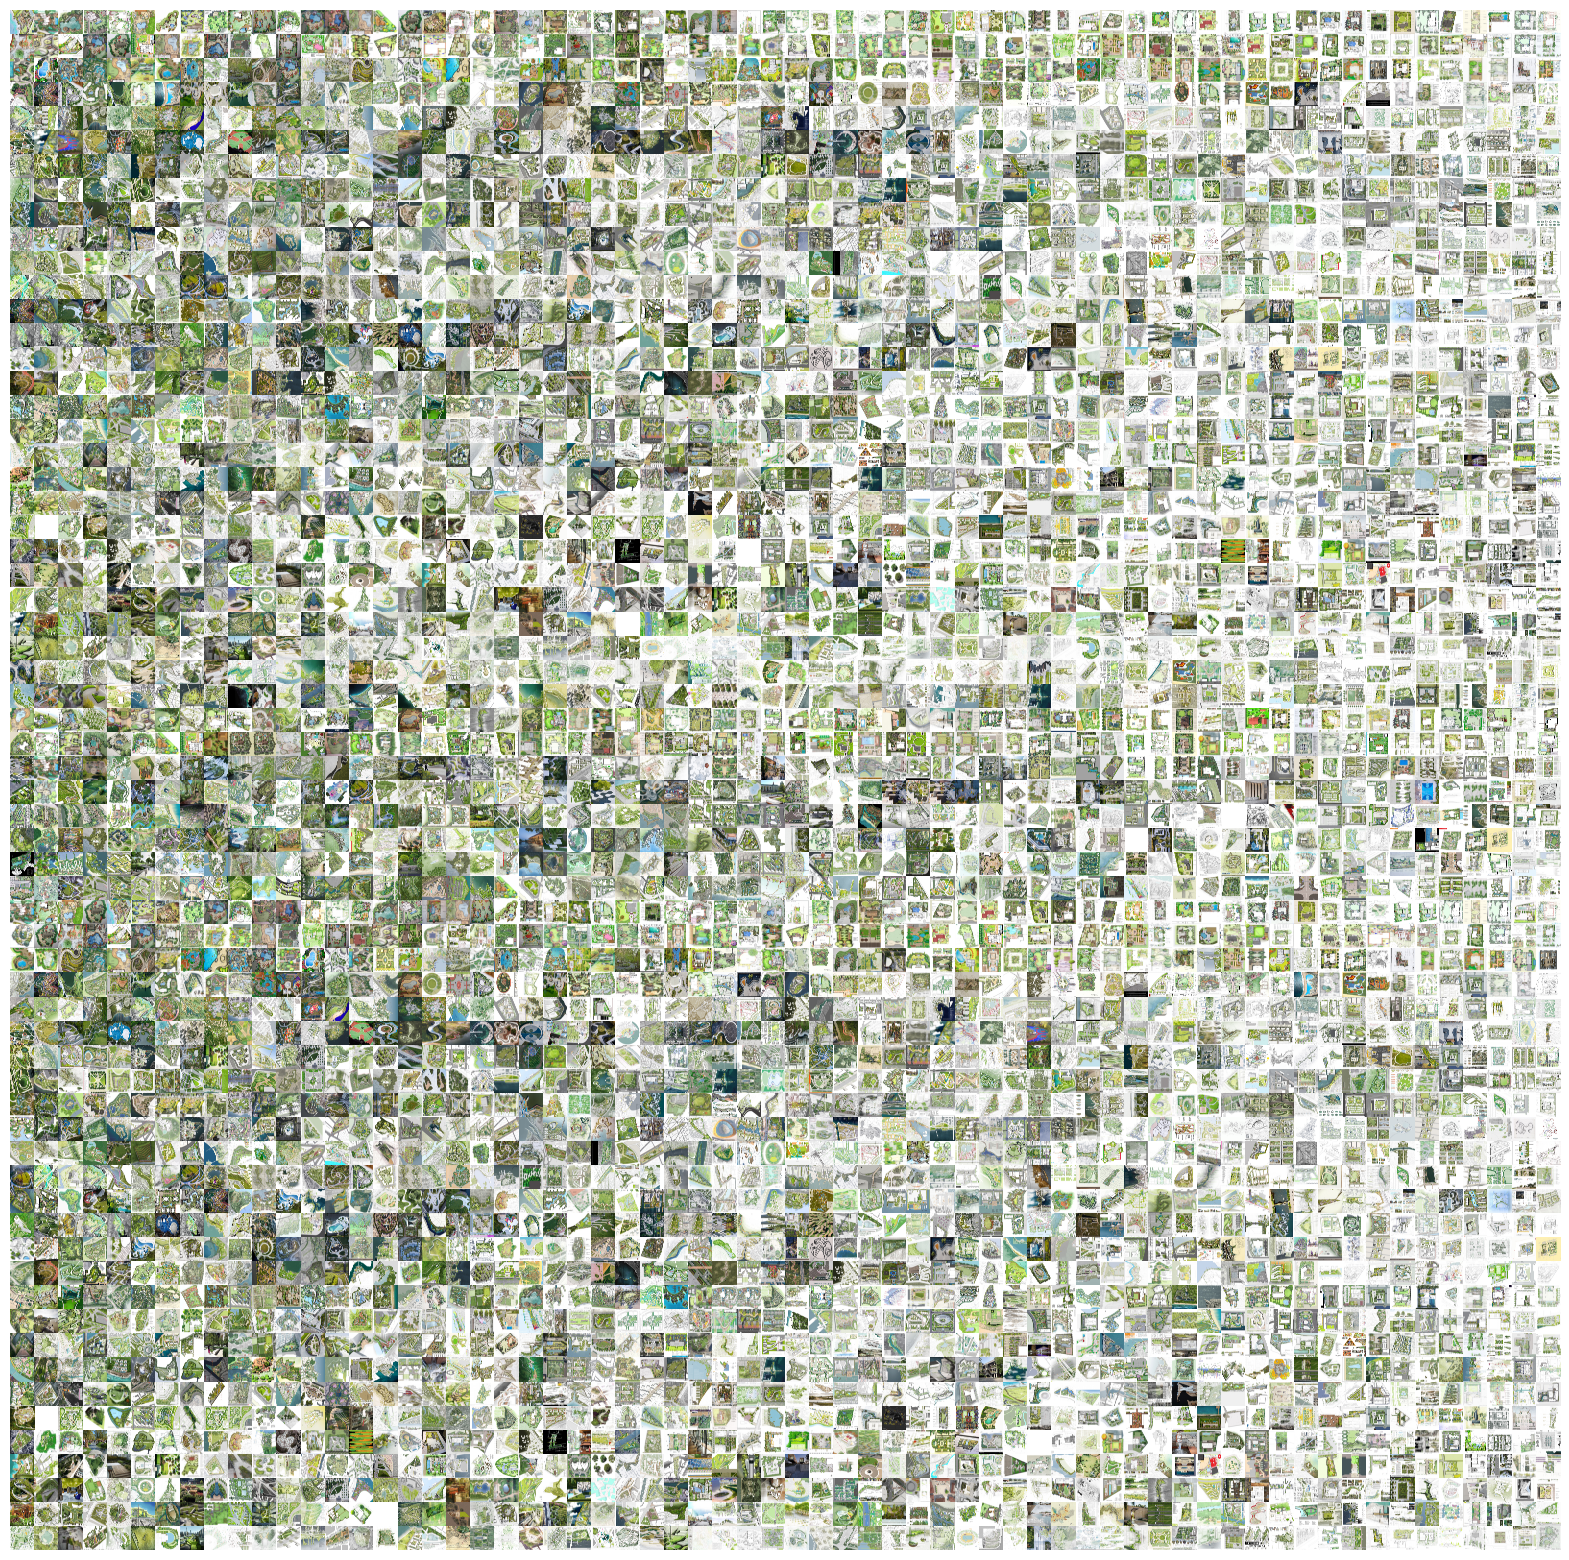

In [6]:
def rotate_image(img, angle):
    #Rotate the image by the specified angle.
    if angle == 90:
        return img.rotate(90)
    elif angle == 180:
        return img.rotate(180)
    elif angle == 270:
        return img.rotate(270)
    return img

def mirror_image(img):
    #Mirror the image horizontally.
    return img.transpose(Image.FLIP_LEFT_RIGHT)

def ensure_rgb(img):
    #Ensure the image is in RGB format.
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

# Get all image file names in the folder
image_files = os.listdir(folder_path)
image_files = [f for f in image_files if f.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))]

# Determine the number of times each image needs to be used
num_repeats = -(-size_sqr // len(image_files))  # Ceiling division

# Create an empty list to store all image features
image_features = []
features_list = []

# Load the pre-trained VGG19 model
model = VGG19(weights='imagenet', include_top=False)

for repeat in range(num_repeats):
    for image_file in image_files:
        img_path = os.path.join(folder_path, image_file)
        try:
            # Open the image using PIL (handles more formats, including GIF)
            img = Image.open(img_path)
            img = ensure_rgb(img)

            # Apply transformations
            if repeat == 1:
                img = rotate_image(img, 90)
            elif repeat == 2:
                img = rotate_image(img, 180)
            elif repeat == 3:
                img = rotate_image(img, 270)
            elif repeat == 4:
                img = mirror_image(img)

            # Resize and preprocess for VGG19 model
            resized_img = cv2.resize(np.array(img), (32, 32))  # Convert PIL image to NumPy array for resizing
            img_array = image_utils.img_to_array(resized_img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            # Extract features
            features = model.predict(img_array)
            features_flatten = features.flatten().tolist()
            image_features.append((image_file, features_flatten))
            features_list.append(features_flatten)
        except IOError:
            print(f"Could not read image {image_file}, skipping.")

# Use PCA to reduce the dimensionality of the features
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_list)

# Replace the original features with the reduced features
for i in range(len(image_features)):
    image_features[i] = (image_features[i][0], reduced_features[i])

# Create a grid of images
fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20), gridspec_kw={'wspace': 0, 'hspace': 0})

for i in range(grid_size):
    row_images = sorted(image_features[i*grid_size:(i+1)*grid_size], key=lambda x: x[1][1])
    for j in range(grid_size):
        img_file, _ = row_images[j]
        img_path = os.path.join(folder_path, img_file)
        img = cv2.imread(img_path)

        # Check if the image was successfully read
        if img is None:
            print(f"Could not read image: {img_path}")
            axs[i, j].axis('off')  # Turn off axis for empty grid cells
            continue

        axs[i, j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), aspect='auto')
        axs[i, j].axis('off')

plt.show()
